# 1. Thư viện và dữ liệu

# Mục mới

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mục mới

In [ ]:
! pip install transformers 

In [ ]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Doc du lieu
# Read Trainingset
sentiments_train = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/train/sentiments.txt', header =None, sep ='\n',names = ['Sentiments'], encoding='utf-8')
sents_train = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/train/sents.txt', header = None, sep ='\n', names = ['Sentences'])
topics_train = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/train/topics.txt', header = None, sep ='\n', names = ['Topics'])

train = pd.concat([sentiments_train, sents_train, topics_train], axis = 1)

#------------------
#Read Devset
sentiments_dev = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/dev/sentiments.txt', header =None, sep ='\n',names = ['Sentiments'], encoding='utf-8')
sents_dev = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/dev/sents.txt', header = None, sep ='\n', names = ['Sentences'])
topics_dev = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/dev/topics.txt', header = None, sep ='\n', names = ['Topics'])

dev = pd.concat([sentiments_dev, sents_dev, topics_dev], axis = 1)
#-----------------
# Read Testset
sentiments_test = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/test/sentiments.txt', header =None, sep ='\n',names = ['Sentiments'], encoding='utf-8')
sents_test = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/test/sents.txt', header = None, sep ='\n', names = ['Sentences'])
topics_test = pd.read_csv('/content/drive/MyDrive/ UIT-VSFC/test/topics.txt', header = None, sep ='\n', names = ['Topics'])

test = pd.concat([sentiments_test, sents_test, topics_test], axis = 1)
# train = pd.read_excel("train_nor_811.xlsx")
# dev = pd.read_excel("valid_nor_811.xlsx")
# test = pd.read_excel("test_nor_811.xlsx")

# train
X_train = train['Sentences']
y_train = train['Sentiments'].values

X_dev = dev['Sentences']
y_dev = dev['Sentiments'].values

X_test = test['Sentences']
y_test = test['Sentiments'].values

print(len(train))
print(len(dev))
print(len(test))

11426
1583
3166


In [ ]:
train['Topics'].value_counts()

0    8166
1    2201
3     562
2     497
Name: Topics, dtype: int64

In [ ]:
# encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

## XLM_R

In [ ]:
# Khai bao pre-trained
xlm_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels = 4)
xlm_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "pos

In [ ]:
train_encodings = xlm_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = xlm_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = xlm_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [ ]:
train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

xlm_trainer = Trainer(
    model=xlm_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# huan luyen mo hinh

xlm_trainer.train()

***** Running training *****
  Num examples = 11426
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3575


Step,Training Loss
500,0.502400
1000,0.334600
1500,0.244800
2000,0.213100
2500,0.173200
3000,0.133700
3500,0.111000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=3575, training_loss=0.24122476737816018, metrics={'train_runtime': 991.1323, 'train_samples_per_second': 57.641, 'train_steps_per_second': 3.607, 'total_flos': 3812354242108800.0, 'train_loss': 0.24122476737816018, 'epoch': 5.0})

In [ ]:
 # Du doan 
y_pred_classify = xlm_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 3166
  Batch size = 16


In [ ]:
# Danh gia mo hinh
y_true = y_test_encoding

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = round(f1_score(y_true, y_pred, average='micro'),4)*100

print("F1 - micro: " + str(evaluation))

evaluation = round(f1_score(y_true, y_pred, average='macro'),4)*100
print("F1 - macro: " + str(evaluation))

evaluation = round(f1_score(y_true, y_pred, average='weighted'),4)*100
print("F1 - weighted : " + str(evaluation))

[[1364   13   32]
 [  39   78   50]
 [  51   13 1526]]
F1 - micro: 93.75
F1 - macro: 82.76
F1 - weighted : 93.37


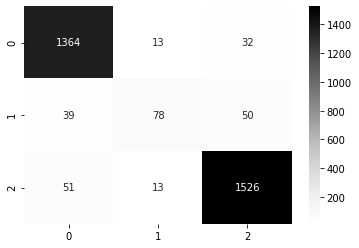

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})

In [ ]:
from sklearn.metrics import classification_report
target_name = ['0','1','2' ,'3']
print(classification_report(y_true, y_pred, target_names=target_name))

ValueError: ignored

In [ ]:
import tensorflow as tf
from keras.models import load_model

xlm_trainer.save('xlm_.h5')
xlm_trainer.save_weights('xlm_weight.h5')

In [ ]:
new_model = load_model('xlm_.h5')